<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_hierarchy_flow_using_select_speaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Hierarchy flow using select_speaker

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

This notebook is about restricting the transition paths within agents. Suppose we have the following setup:

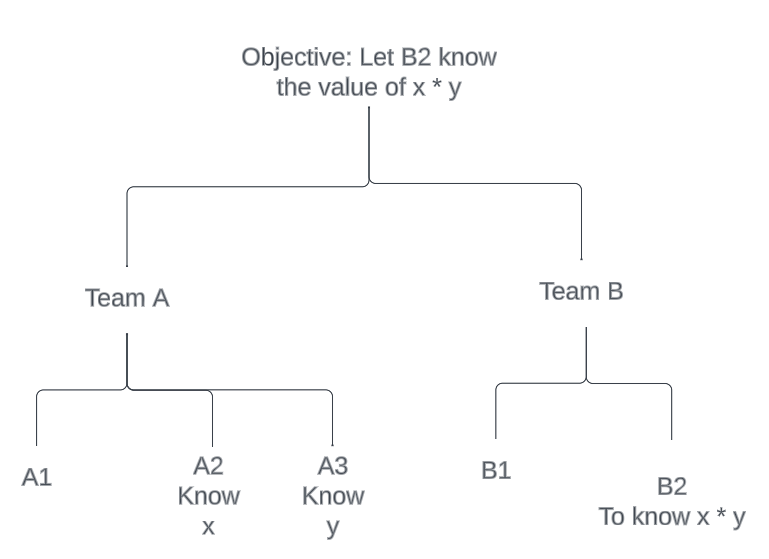

Constraints:
- Team leaders can talk amongst themselves
- A team can talk amongst themselves

Benefits
- By limiting team members can talk to team members, we bring focus to the team.
- Information flow from Team A to Team B is made more efficient to let the X1s talk amongst themselves. It is more efficient as group members can only pass their turns to their group-mates, keeping the discussion tight.


## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [1]:
%%capture --no-stderr
# %pip install pyautogen~=0.2.0b4

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [2]:
import autogen

print(autogen.__version__)

# The default config list in notebook.
config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

# Contributor's config - Please replace with your own, I have replaced mine with an Azure OpenAI endpoint.
config_list_gpt4 = autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["gpt-4"],
        },
    )

0.2.0b1


It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choosing "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Extending GroupChat


Custom Speaker Selection Logic: The CustomGroupChat class allows us to define our own logic for selecting the next speaker in the group chat. The base GroupChat class has a default logic that may not be suitable for all scenarios.


Content-Driven Speaker Selection: This custom class lets us select the next speaker based on the content of the last message, like "NEXT: A2" or "TERMINATE". The base GroupChat class does not have this capability.

Team-Based Logic: The custom class enables team-based logic for speaker selection. It allows the next speaker to be chosen from the same team as the last speaker or from a pool of team leaders, which is something the base GroupChat class does not offer.

Previous Speaker Exclusion: The CustomGroupChat class includes logic to prevent the last speaker and the previous speaker from being selected again immediately, which adds more dynamism to the conversation.

Flexibility: Extending the base GroupChat class allows us to preserve the existing functionalities and methods while adding new features specific to our needs. This makes the code more modular and easier to maintain.

Special Cases Handling: The custom class can also handle special cases, like terminating the chat or transitioning to a 'User_proxy', directly within its select_speaker method.



In [3]:
llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

In [4]:
from autogen.agentchat.groupchat import GroupChat
from autogen.agentchat.agent import Agent
from autogen.agentchat.assistant_agent import AssistantAgent

In [5]:
import random
from typing import List, Dict

class CustomGroupChat(GroupChat):
    def __init__(self, agents, messages, max_round=10):
        super().__init__(agents, messages, max_round)
        self.previous_speaker = None  # Keep track of the previous speaker
    
    def select_speaker(self, last_speaker: Agent, selector: AssistantAgent):
        # Check if last message suggests a next speaker or termination
        last_message = self.messages[-1] if self.messages else None
        if last_message:
            if 'NEXT:' in last_message['content']:
                suggested_next = last_message['content'].split('NEXT: ')[-1].strip()
                print(f'Extracted suggested_next = {suggested_next}')
                try:
                    return self.agent_by_name(suggested_next)
                except ValueError:
                    pass  # If agent name is not valid, continue with normal selection
            elif 'TERMINATE' in last_message['content']:
                try:
                    return self.agent_by_name('User_proxy')
                except ValueError:
                    pass  # If 'User_proxy' is not a valid name, continue with normal selection
        
        team_leader_names = [agent.name for agent in self.agents if agent.name.endswith('1')]

        if last_speaker.name in team_leader_names:
            team_letter = last_speaker.name[0]
            possible_next_speakers = [
                agent for agent in self.agents if (agent.name.startswith(team_letter) or agent.name in team_leader_names) 
                and agent != last_speaker and agent != self.previous_speaker
            ]
        else:
            team_letter = last_speaker.name[0]
            possible_next_speakers = [
                agent for agent in self.agents if agent.name.startswith(team_letter) 
                and agent != last_speaker and agent != self.previous_speaker
            ]

        self.previous_speaker = last_speaker

        if possible_next_speakers:
            next_speaker = random.choice(possible_next_speakers)
            return next_speaker
        else:
            return None


In [6]:
# Termination message detection
def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False

In [7]:
# Initialization
agents_A = [
    AssistantAgent(name='A1', 
                   system_message="You are a team leader A1, your team consists of A2, A3. You can talk to the other team leader B1, whose team member is B2.",
                   llm_config=llm_config),
    AssistantAgent(name='A2', 
                   system_message="You are team member A2, you know the secret value of x but not y, x = 9. Tell others x to cooperate.",
                   llm_config=llm_config),
    AssistantAgent(name='A3', 
                   system_message="You are team member A3, You know the secret value of y but not x, y = 5. Tell others y to cooperate.",
                   llm_config=llm_config)
]

agents_B = [
    AssistantAgent(name='B1', 
                   system_message="You are a team leader B1, your team consists of B2. You can talk to the other team leader A1, whose team member is A2, A3. Use NEXT: A1 to suggest talking to A1.",
                   llm_config=llm_config),
    AssistantAgent(name='B2', 
                   system_message="You are team member B2. Your task is to find out the value of x and y and compute the product. Once you have the answer, say out the answer and append a new line with TERMINATE.",
                   llm_config=llm_config)
]

# Terminates the conversation when TERMINATE is detected.
user_proxy = autogen.UserProxyAgent(
        name="User_proxy",
        system_message="Terminator admin.",
        code_execution_config=False,
        is_termination_msg=is_termination_msg,
        human_input_mode="NEVER")

list_of_agents = agents_A + agents_B
list_of_agents.append(user_proxy)

# Create CustomGroupChat
group_chat = CustomGroupChat(
    agents=list_of_agents,  # Include all agents
    messages=['Everyone cooperate and help agent B2 in his task. Team A has A1, A2, A3. Team B has B1, B2. Only members of the same team can talk to one another. Only team leaders (names ending with 1) can talk amongst themselves. You must use "NEXT: B1" to suggest talking to B1 for example; You can suggest only one person, you cannot suggest yourself or the previous speaker; You can also dont suggest anyone.'],
    max_round=30
)


# Create the manager
llm_config = {"config_list": config_list_gpt4, "cache_seed": None}  # cache_seed is None because we want to observe if there is any communication pattern difference if we reran the group chat.
manager = autogen.GroupChatManager(groupchat=group_chat, llm_config=llm_config)


# Initiates the chat with B2
agents_B[1].initiate_chat(manager, message="Find the product of x and y, the other agents know x and y.")

B2 (to chat_manager):

Find the product of x and y, the other agents know x and y.

--------------------------------------------------------------------------------
B1 (to chat_manager):

NEXT: A1
Can you or any of your team members provide the values for x and y? B2 needs these values to complete a task.

--------------------------------------------------------------------------------
Extracted suggested_next = A1
Can you or any of your team members provide the values for x and y? B2 needs these values to complete a task.
A1 (to chat_manager):

Sure B1, let me check with my team. 

NEXT: A2, A3
Could either of you provide the values for x and y? B2 needs these values to complete a task.

--------------------------------------------------------------------------------
Extracted suggested_next = A2, A3
Could either of you provide the values for x and y? B2 needs these values to complete a task.
A2 (to chat_manager):

Sure, I hold the value for x. We know x is equal to 9. A3, could you p